<center><img src='https://www.isel.pt/sites/default/files/SCI/Identidade/logo_ISEL_simplificado_cor.png' width=350>

<h3><center>Instituto Superior de Engenharia de Lisboa</h3>
<h3><center>Departamento Engenharia Eletrónica e Telecomunicações de Computadores</h2>
<h3><center>Licenciatura em Engenharia Informática e Multimédia</h2>
<h3><center>Aprendizagem Automática</h2>

<h1> <center>Classificação de Críticas de Cerveja </h1>

<h4><center>Ano Letivo 2023/2024 <br> Turma 51D</h3>
<h4><center> Docente: <br> Gonçalo Marques </h3>
<h4> <center> Aluno: <br> Duarte Gonçalves nº46484 </h3>
<hr>

# <center> Índice
1. [Introdução](#introducao)
2. [Pressupostos Teóricos](#teoria)\
    2.1 [Aprendizagem Supervisionada](#as)<br>
    2.2 [Aprendizagem Não Supervisionada](#ans)
3. [Inicialização e Verificação dos Dados](#dados)
4. [Desenvolvimento](#desenvolvimento)\
    4.1 [Restruturação de Dados](#desenvolvimento-1)\
        4.1.1 [Desconstrução dos Dicionários](#desenvolvimento-1-1)<br>
        4.1.2 [Análise e Limpeza de Dados](#desenvolvimento-1-2)\
    4.2 [Vocabulário](#desenvolvimento-2)\
        4.2.1 [Limpeza de Texto](#desenvolvimento-2-1)<br>
        4.2.2 [TfidfVectorizer](#desenvolvimento-2-2)<br>
        4.2.3 [Stemmer](#desenvolvimento-2-3)<br>


<hr>

# <center> 1. Introdução <a id="introducao"></a>

No âmbito da unidade curricular de Aprendizagem Automática, foi proposto o desenvolvimento de um algoritmo que classifica-se críticas de várias cervejas, de acordo com as diversas categorias de classificação como a sua avaliação geral, cheiro, sabor, textura e estilo, como projeto final da mesma, através do uso dos diferentes classificadores lecionados na unidade curricular.<br>

Resumidamente, este projeto tem como objetivos determinar a qualidade de uma cerveja baseado no que foi escrito sobre a mesma. O que para tal, surgem duas tarefas de classificação a ser implementadas: 
- **Classificação Binária** - Determinar os dados positivos e negativos das críticas;
- **Classificação Multi-Classe** - Determinar a pontuação das críticas com base nas várias caracteristicas (Overall, smell, taste);

Para cada um dos diferentes tipos de classificação, será necessário determinar o melhor vocabulário a utilizar e ainda ter em consideração a dimensão da própria critica e da utilidade de certas da mesma.<br>

Este documento, apresenta todos os passos procedidos para o desenvolvimento desse mesmo algoritmo tendo, analises dos dados e também justificações de usos dos classificadores usados assim como dos procedimentos feitos que permitem chegar a uma conclusão aceitável.<br>
<hr>

# <center> 2. Pressupostos Teóricos <a id="teoria"></a>
## 2.1 Aprendizagem Supervisionada <a id="as"></a>
Na Aprendizagem supervisionada, é feito um ensino de dados rotulados ao algoritmo, onde este aprende a mapear as entradas para as saídas desejadas. Isto é, é fornecido ao algoritmo um conjunto de informações já dividas por classe e que posteriormente é fornecido um novo conjunto de informação para serem analisado e classificados da mesma forma, comparando as com as já conhecidas e associando-as à classe onde melhor se enquandrará. Podendo este ser divididos nos seguintes :<br>
- **Classificação:** Os dados estão divididos em duas ou mais classes e o objetivo é decidir a quais classes novos dados pertencem
- **Regressão:** Prever o valor de uma dada vari ´avel baseado nos valores de outras

Neste tipo de aprendizagem encontram-se os seguintes classificadores, que foram aprendidos nesta Unidade Curricular e utilizados neste projeto:
- **Regressão Logística** - estima a probabilidade de uma determinada entrada pertencer a uma classe ou outra;
- **K-Vizinhos (KNN)** - classifica uma nova instância baseada na maioria das classes dos k exemplos mais próximos no conjunto de treino;
- **Máquina de Vetores de Suporte (SVM)** - procura um hiperplano que maximize a separação entre as classes no espaço de atributos;
-**Análise em Discriminante Lineares (LDA)** - classificação e redução de dimensionalidade;

## 2.2 Aprendizagem Não Supervisionada <a id="ans"></a>
Na Aprendizagem não supervisionada, é feito um ensino de dados não rotulados ao algoritmo, onde este aprende a mapear as entradas para as saídas não conhecidas. Isto é, é fornecido ao algoritmo um conjunto de informações e este terá que encontrar padrões, estruturas ou grupos nos dados sem orientação externa.<br>
Sobre esta aprendizagem , na unidade curricular, foram leccionados os seguintes classificadores:
- **Clustering:**<br>
    -**K-Médias** - agrupa os dados em k clusters, onde k é um número predefinido;
    -**Dendrogramas** - mostra como as instâncias ou grupos de instâncias são agrupados uns nos outros à medida que o algoritmo de agrupamento hierárquico é aplicado; 
- **Análise em Componentes principais (PCA)** - usado para a redução de dimensionalidade e também pode ser usado como uma ferramenta para identificar padrões ou estruturas nos dados;<br>

O projeto, tem como base a utilização de classificadores do tipo de aprendizagem supervisionada, mas no entanto dá a opção de aplicarem alguns classificadores da aprendizagem não supervisionada
<hr>

# <center> 3. Inicialização e Verificação dos Dados <a id="dados"></a>

## Bibliotecas

In [1]:
import pickle
import sklearn
import nltk
import re
import cv2

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer

O projeto foi apresentado com os seguintes ficheiros:<br>
- "rateBeer75Ktrain.p", que apresenta 75 mil criticas para treino dos classificadores;
- "rateBeer25Ktest.p", que apresenta 25 mil criticas para teste dos classificadores;

Verifica-se que dentro destes ficheiros, as criticas são compostas por várias caracteristicas, entre elas o nome, estilo e mais importante o sabor,cheiro,a crítica e a classificação final da mesma, como se pode observar em baixo.

In [2]:
#Leitura de Dados fornecidos pelo Docente
beerTrain = pickle.load(open('Dados/rateBeer75Ktrain.p','rb'))
beerTest = pickle.load(open('Dados/rateBeer25Ktest.p','rb'))

#Exemplo de como aceder aos dados de Treino
print(type(beerTrain))
listBeerTrain = list(beerTrain.keys())
BeerTrain0 = beerTrain[listBeerTrain[0]]
print(BeerTrain0.keys(),"\n")
print(BeerTrain0)
print(BeerTrain0["overall"], type(BeerTrain0["overall"]))
print(BeerTrain0["smell"], type(BeerTrain0["smell"]))
print(BeerTrain0["taste"], type(BeerTrain0["taste"]))
print(BeerTrain0["review"])


<class 'dict'>
dict_keys(['name', 'style', 'who', 'feel', 'look', 'smell', 'taste', 'overall', 'review']) 

{'name': 'Anderson Valley Brother Davids Double', 'style': 'Abbey Dubbel', 'who': 'dmtroyer', 'feel': '3/5', 'look': '3/5', 'smell': '2/5', 'taste': '3/5', 'overall': '4/10', 'review': '22oz.  Pours dark brown with a red rim and off-white head.  Nose is mostly sweet malt with fairly noticeable alcohol depending on the temperature.  Flavor is sweet malt with raisin and banana yeast with some slight spice on the finish.  Very true to the style, but less than inspiring.'}
4/10 <class 'str'>
2/5 <class 'str'>
3/5 <class 'str'>
22oz.  Pours dark brown with a red rim and off-white head.  Nose is mostly sweet malt with fairly noticeable alcohol depending on the temperature.  Flavor is sweet malt with raisin and banana yeast with some slight spice on the finish.  Very true to the style, but less than inspiring.


<hr>

# <center> 4. Desenvolvimento <a id="desenvolvimento"></a>
## 4.1 Restruturação de Dados <a id="desenvolvimento-1"></a>
### 4.1.1 Desconstrução dos Dicionários<a id="desenvolvimento-1-1"></a>
Para uma melhor manipulação dos dados fornecidos, criou-se uma função `DeconstructDict()` que transforma os dados dos dicionários fornecidos, num novo tipo de dicionário que apresenta apenas os dados necessário para a realização do projeto (review, overall, smell, e taste).<br>

Para uma facilitação do mesmo os valores string do "**overall**", "**smell**" e "**taste**" são transformados em tipo inteiro para uma melhor utilização em futuros métodos.

In [3]:
def DeconstructDict(data):
    """
    Função que transforma o dicionário de dados fornecida pelo docente num 
    novo dicionário de dados
    @param data: dicionário de dados fornecida pelo docente
    @return newDict: novo dicionário de dados
    """ 
    newDict = {'review':[],'overall':[],'smell':[],'taste':[]}
    listData = list(data.keys())
    for i in range(len(listData)):
        newDict['review'].append(data[listData[i]]['review'])
        newDict['overall'].append(int(data[listData[i]]['overall'].split('/')[0]))
        newDict['smell'].append(int(data[listData[i]]['smell'].split('/')[0]))
        newDict['taste'].append(int(data[listData[i]]['taste'].split('/')[0]))
    return newDict['review'], np.array(newDict['overall']), np.array(newDict['smell']), np.array(newDict['taste'])

Docs_train, overall_train, smell_train, taste_train = DeconstructDict(beerTrain)
Docs_test, overall_test, smell_test, taste_test = DeconstructDict(beerTest)

### 4.1.2 Análise e Limpeza de Dados<a id="desenvolvimento-1-2"></a>
Nesta secção, utiliza-se os dados que anteriormente foram recolhidos da desconstrução dos dicionários fornecidos e pretende-se então aplicar todas as condicionantes que permitam uma boa aprendizagem por parte do algoritmo e que futuramente serão utilizados pelos classifcadores selecionados.<br>
É de realçar que, primeiramente começou-se pelo tratamento dos valores inteiros de classifcação, tanto para a classificação binária (**Overall**) como para a classificação multi-classe(**Overall**,**Smell**,**Taste**), e a seguir será tratado as críticas das mesmas com a formação de um novo vocabulário

In [4]:
def dataBin(data):
    """
    Método que transforma um array de dados num array binário de acordo com
    os limites e ainda a remoção de críticas de cervejas com classificação 
    entre 2 e 9.
    @param data: lista de dados 
    @return data: lista de dados condicionada
    @return condition: condição de dados
    """
    data[data <= 2] = 0 #Cerveja muito má 
    data[data >= 9] = 1 #Cerveja muito boa
    condition = (data > 2) & (data < 9) 
    return data,condition

def drawGraphics(type, overallB, overallM, smell, taste):
    """
    Método que desenha gráficos de acordo com o tipo de dados fornecidos
    @param type: tipo de dados
    @param overallB: array de dados binários
    @param overallM: array de dados multi-classe
    @param smell: array de dados multi-classe (smell)
    @param taste: array de dados multi-classe (taste)
    """
    print("Criticas com avaliação muito boa (" + type + "): ", np.sum(overallB == 1))
    print("Criticas com avaliação muito má (" + type + "): ", np.sum(overallB == 0),'\n')
    print("Média de Avaliação Overall (" + type + "): ", np.mean(overallM),'/10')
    print("Média de Avaliação Smell (" + type + "): ", np.mean(smell),'/5')
    print("Média de Avaliação Taste (" + type + "): ", np.mean(taste),'/5')

    plt.figure(figsize=(25,6))
    plt.subplot(141)
    plt.title('Binário - Overall (' + type + ')')
    labels, counts = np.unique(overallB, return_counts=True)
    plt.bar(labels, counts, align='center')
    plt.xticks(labels,['Muito Má', 'Muito Boa'], size='large')
    plt.ylabel('Número de Críticas')
    plt.xlabel('Classificação')
    plt.subplot(142)
    plt.title('Multi-Classe - Overall (' + type + ')')
    labels, counts = np.unique(overallM, return_counts=True)
    plt.bar(labels, counts, align='center')
    plt.xticks(np.arange(1, 11))
    plt.ylabel('Número de Críticas')
    plt.xlabel('Classificação')

    plt.figure(figsize=(15,5))  
    labels, counts = np.unique(smell, return_counts=True)
    plt.subplot(121)
    plt.title('Multi-Classe - Smell (' + type + ')')
    plt.bar(labels, counts, align='center')
    plt.xticks(np.arange(0, 6))
    plt.ylabel('Número de Críticas')
    plt.xlabel('Classificação')

    labels, counts = np.unique(taste, return_counts=True)
    plt.subplot(122)
    plt.title('Multi-Classe - Taste (' + type + ')')
    plt.bar(labels, counts, align='center')
    plt.xticks(np.arange(0, 6))
    plt.xlabel('Classificação') 

#### Análise de Dados de Treino</a>

Criticas com avaliação muito boa (train):  5052
Criticas com avaliação muito má (train):  3346 

Média de Avaliação Overall (train):  5.67136 /10
Média de Avaliação Smell (train):  3.0184 /5
Média de Avaliação Taste (train):  3.03116 /5


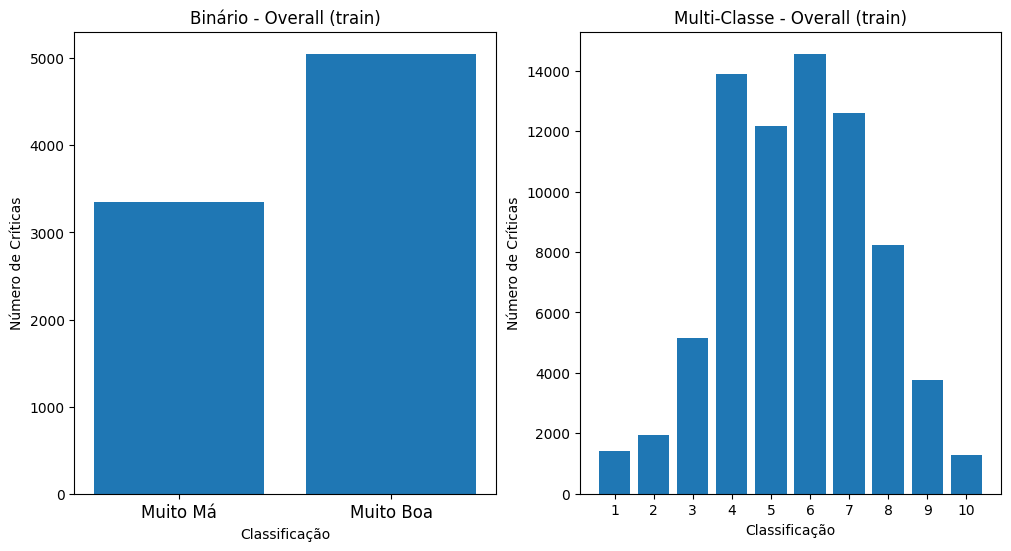

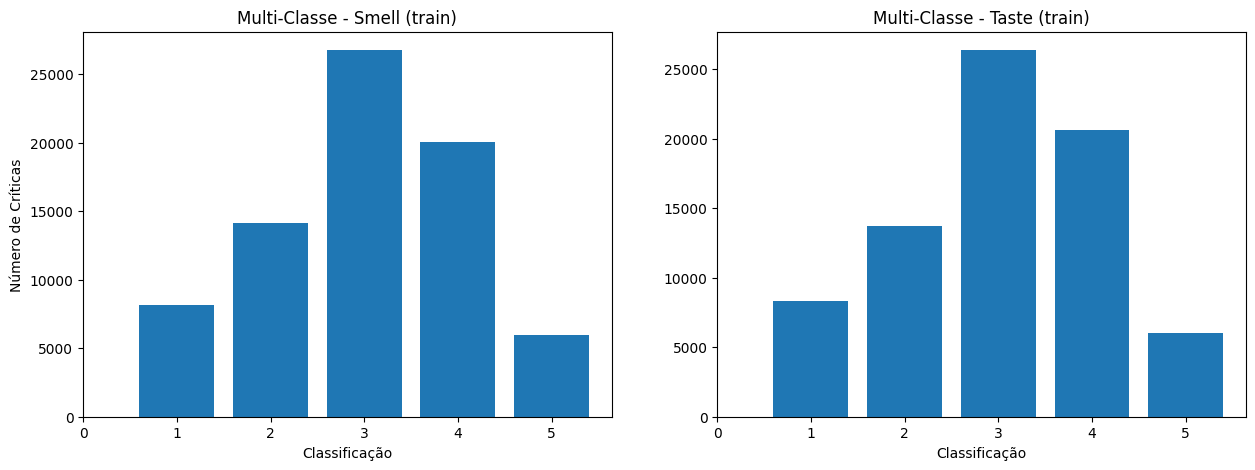

In [5]:
#Dados de Treino
overallB_train,condition = dataBin(overall_train.copy()) #Classificação binária 
overallM_train = overall_train.copy() #Classificação multi-classe
drawGraphics('train',np.delete(overallB_train,condition), overallM_train, smell_train, taste_train) 

Depois de tratamento destes dados, como podemos observar nos valores em cima apresentados, verificamos que nos dados de treino, `overallB_train`, possui-se **5052 críticas** que estão dentro da classificação **Muito boa**, e **3346 classificações** consideradas **Muito Más**. <br>
Adicionalmente para o classificador Multi-classes,`overallM_train` `smell_train` e `taste_train`, fez-se uma média para os valores de classificação e demonstrou-se também com gráficos para uma visualização mais detalhada, podendo-se concluir que os valores parecem corresponder com o indicado e pretendido por parte do enunciado.<br>

#### Análise de Dados de Teste

Criticas com avaliação muito boa (test):  1111
Criticas com avaliação muito má (test):  2429 

Média de Avaliação Overall (test):  5.047 /10
Média de Avaliação Smell (test):  2.66076 /5
Média de Avaliação Taste (test):  2.71604 /5


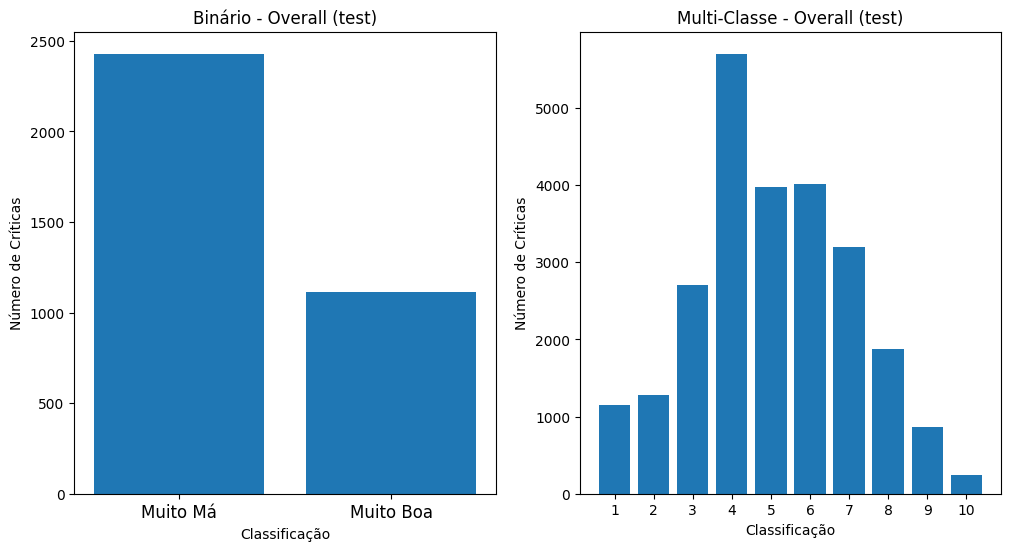

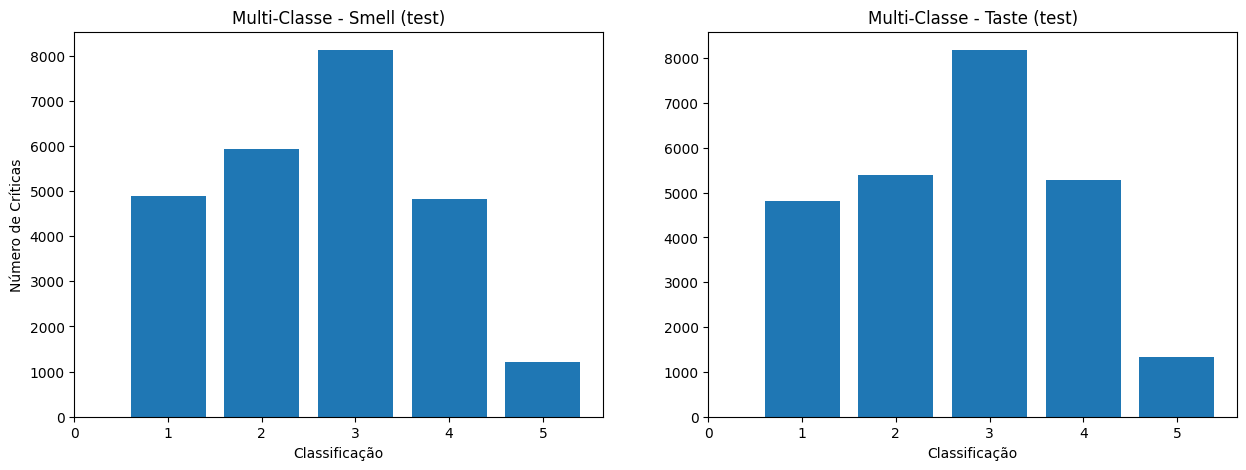

In [6]:
#Dados de Teste
overallB_test, condition = dataBin(overall_test.copy()) #Classificação binária
overallM_test = overall_test.copy() #Classificação multi-classe 
drawGraphics('test',np.delete(overallB_test,condition), overallM_test, smell_test, taste_test)

Assim como foi feito nos dados de treino, nesta parte, é apresentado as mesmas caracteristicas de avaliação dos valores de classificação e pode-se observar que, apesar de serem menos classificações que as de treino, existe uma grande quantidade de classificações que são consideradas **Muito Más (2429)**, em relação as que são consideradas **Muito Boas (1111)**.<br>
Mais uma vez foram também apresentadas os valores médios das caracteristicas para a classificação multi-classe, que em comparação com os dados de treino, apresentam uma ligeira redução das mesmas. no entanto, com a visualização dos gráficos  percebe-se que continua a haver bastantes classificações iguais a 3/5, em relação ao taste e smell, e tendo um maior peso o valor 4/10 no overalal da cerveja.<br>

Tendo esta parte concluida, segue-se para o tratamento das críticas e consequentemente a criação de um vocabulário.

## 4.2 Vocabulário <a id="desenvolvimento-2"></a>

Para a realização de uma aprendizagem automática com dados do tipo de texto, é necessário representar cada documento, neste caso cada crítica, como um vetor numérico. Para tal, é feito uma remoção das ordens das palavras, dando maior importância ao peso individual que estas terão para a classificação.<br>

O Resultado desta construção de vocabulário é a matriz `documento-termo` ou `corpus`. Resumidamente, para a inicialização do projeto ter-se-á que ter em conta os seguintes passos para a realização desta matriz:
- **Tokenization**, onde o documento é dividido em palavras, ou tokens;
- **Construção do Vocabulário**, onde se um vocabulário por todas as palavras presentes na matriz;
- **Codificação**, onde com base no vocabulário construido, se conta o número de ocorrências de cada palavra e ainda é feito uma vetorização dos documentos com valores proporcionais ao números de vezes da palavra do documento;<br>

No entanto, a realização deste algoritmo, poderá trazer algumas inconsistência para o *corpus*, devido à existência de artigos definidos/indefinidos, pronomes ou até mesmo conjunções de verbo que acabam por significar o mesmo e por isso tornam-se redundantes. A solução mais indicada, é a utilização de filtros para as palavras, com hiper-parâmetros que irão filtrar essas palavras que são irrelevantes para a classificação. 

### 4.2.1 Limpeza de Texto <a id="desenvolvimento-2-1"></a>
Para a inicialização da construção de um vocabulário é necessário começar com a  limpeza das mesmas removendo caracteres especiais e outros elementos que não sejam relevantes para a análise dos dados, para tal, foi desenvolvido o método `textCleaning`.<br>


In [7]:
Docs_test_redux = Docs_test.copy()[:25]
print('Crítica Reduzida: \n', Docs_test_redux)

Crítica Reduzida: 
 ['Tap, Toronado during CBC week.  Good oyster flavor in this beer, but the roast and hops came through too harshly for my tastes.  Earthy and a bit mineraly.  I wish that I had nabbed a bottle because I imagine that this one had a good chance of settling down and letting those salty, earthy notes combine with more of the dark chocolate lurking beneath the roast.', 'Courtesy of Degarth. Pours dark mahogany with tan head. The aroma is big with earthiness mixed with caramel covered apples, prunes, the salty seaweedy sea shore and a fish market. The taste is a bit on the thin side but smooth too with dark roasted to burnt malts, chilli pepper notes, full up fish market counter oyster juice and earthiness. In the background is a mild sense of caramel. The fish/oyster sensation works well here with the earthy hops and roasty malts. Nice.', 'Tasted on 8/1/11 from a 12oz bottle obtained in a trade, it was a bit of a gusher.  Pours thick, oily black with a massive tan head t

In [8]:
def textCleaning(documentos):
    """
    @param documentos: lista de reviews
    @param bin: se os dados forem binários
    @return documentos: lista de reviews limpos
    """
    documentos = [doc.replace('<br />', ' ') for doc in documentos]
    documentos = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+' , ' ', doc) for doc in documentos]
    return documentos

print('Crítica Original: \n', Docs_test_redux[2])
print('Tamanho da Crítica Original: ', len(Docs_test_redux[2]))
Docs_test_redux = textCleaning(Docs_test_redux)
print('Crítica Após Limpeza: \n', Docs_test_redux[2])
print('Tamanho da Crítica Após Limpeza: ', len(Docs_test_redux[2]))


Crítica Original: 
 Tasted on 8/1/11 from a 12oz bottle obtained in a trade, it was a bit of a gusher.  Pours thick, oily black with a massive tan head that slowly recedes to some spotty lace and a thin collar.  This is the first oyster stout I have ever had where the oyster is actually discernable.  There are aromas of chocolate, roasted malt, and coffee, but the overwhelming aroma is of briny and somewhat fishy oyster.  The flavor is the same, starting off with the briny and somewhat fishy taste, and then moving on to the lightly sweet chocolate, vanilla, and a hint of coconut, and finishing with bitter dark chocolate and coffee.  The body is medium with average, but stinging carbonation and a long bitter coffee, coconut, and briny finish.
Tamanho da Crítica Original:  731
Crítica Após Limpeza: 
 Tasted on from a oz bottle obtained in a trade it was a bit of a gusher Pours thick oily black with a massive tan head that slowly recedes to some spotty lace and a thin collar This is the f

Como se consegue observar, o resultado após a limpeza, mostra que os caracteres especiais e números foram removidos diminuindo o tamanho do documento acerca de 6% do seu valor original. 

### 4.2.2 TfidfVectorizer <a id="desenvolvimento-2-2"></a>
Para ajudar nesta limpeza, será também utilizado a função `TfidfVectorizer()` que é uma junção dos métodos `CountVectorizer`e `TfidfTransformer`e que tem como objetivo fazer a contagem para cada texto, do número de ocorrências de uma palavra e dar mais peso de importância a essas palavras, respetivamente. No entanto, é necessário encontrarmos os melhores parâmetros, minimo de repetição de palavra por documento (**min_df**) e **token_pattern** a serem utilizados antes de aplicar no documento.

In [9]:
min_df = [2, 3, 4]
token_pattern = [r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b']
for df in min_df:
    for token_pat in token_pattern:
        vectorizer = TfidfVectorizer(min_df=df, token_pattern=token_pat)
        vectorizer.fit(Docs_test_redux)
        print('Número de Tokens (min_df =',df,') (token_pattern =',token_pat,'):', len(vectorizer.get_feature_names_out()))
        print('Tokens (min_df =',df,') (token_pattern =',token_pat,'):''\n', vectorizer.get_feature_names_out(),'\n')

Número de Tokens (min_df = 2 ) (token_pattern = \b\w\w+\b ): 217
Tokens (min_df = 2 ) (token_pattern = \b\w\w+\b ):
 ['actually' 'aftertaste' 'ale' 'almost' 'amber' 'an' 'and' 'any' 'are'
 'aroma' 'aromas' 'around' 'as' 'at' 'average' 'back' 'bad' 'balanced'
 'be' 'beer' 'better' 'big' 'bit' 'bitter' 'bitterness' 'black' 'bodied'
 'body' 'bottle' 'brew' 'briny' 'brown' 'burnt' 'but' 'by' 'caramel'
 'carbonation' 'character' 'chocolate' 'christmas' 'citrus' 'clear'
 'cocoa' 'coffee' 'color' 'colored' 'copper' 'courtesy' 'creamy' 'crisp'
 'dark' 'decent' 'deep' 'definitely' 'degarth' 'dense' 'did' 'diminished'
 'disappointing' 'down' 'drink' 'dry' 'drying' 'earthy' 'easy' 'eda' 'end'
 'ever' 'expecting' 'faint' 'fairly' 'fine' 'finish' 'first' 'flavor'
 'flavors' 'foam' 'for' 'from' 'fruit' 'fruity' 'full' 'glass' 'going'
 'good' 'guess' 'had' 'has' 'have' 'head' 'heavy' 'herbal' 'here' 'hint'
 'hop' 'hops' 'huge' 'if' 'in' 'intense' 'is' 'isnt' 'it' 'its' 'itself'
 'ive' 'just' 'khaki' 

De acordo com os resultados anteriormente apresentados chegou-se a conclusão que os melhores parâmetros a utilizar seriam aqueles onde houvesse uma redução significativa das palavras e que não retirasse informação necessária para o algoritmo, e por isso, conclui-se o seguinte:
- **min_df** = 3
- **token_pattern** = \b\w\w\w+\b

### 4.2.3 Stemmer <a id="desenvolvimento-2-3"></a>
Para finalizar a limpeza das criticas é utilizado um **stemmer**, que é o processo de transformar uma palavra na sua raiz, acabando por fazer uma junção de palavras semelhantes. Na Unidade Curricular foram leccionadas, três tipos de Stemmers:
- `Porter Stemmer`: Algoritmo que remove sufixos comuns a plavras para reduzir a sua forma raiz; 
- `Snowball Stemmer`: Uma versão melhorada de Porter Stemmer, com um suporte em várias linguas;
- `Lancaster Stemmer`: Uma versão mais agressiva que o Porter Stemmer; 

In [10]:
def DocsToVector(stemFunc,Docs):
    """
    Método que permite a criação de uma representação tfidf
    apartir da lista de strings fornecida e também do stemmer utilizado
    @param stemFunc: stemmer utilizado
    @param Docs: lista de strings
    @return tokens: lista de tokens
    @return documento_termo
    """
    Docs2 = [' '.join(stemFunc.stem(w) for w in doc.split()) for doc in Docs]
    tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b\w\w\w+\b').fit(Docs2)
    tokens = tfidf.get_feature_names_out()
    return tokens, tfidf.transform(Docs2)

stemmer1 = PorterStemmer()
stemmer2 = SnowballStemmer('english')
stemmer3 = LancasterStemmer()

#Criar Representação tfidf
tokens1,_ = DocsToVector(stemmer1,Docs_test_redux.copy())
tokens2,_ = DocsToVector(stemmer2,Docs_test_redux.copy())
tokens3,_ = DocsToVector(stemmer3,Docs_test_redux.copy())

#Verificação de tokens agrupados por stemmer
print('Número de Tokens com PorterStemmer: ', len(np.unique(tokens1)))
print('Número de Tokens com SnowballStemmer: ', len(np.unique(tokens2)))
print('Número de Tokens com LancasterStemmer:', len(np.unique(tokens3)))

Número de Tokens com PorterStemmer:  121
Número de Tokens com SnowballStemmer:  121
Número de Tokens com LancasterStemmer: 117


O melhor procedimento aqui é selecionar um stemmer que nos forneça um agrupamento significativo de palavras e que ao mesmo tempo não retire "chaves" essenciais para a classificação dos textos feitos pelos criticos.<br>
Por isso, conclui-se que o melhor stemmer a utilizar será o $\textit{\textbf{SnowballStemmer}}$, pois este não apresenta um agrupamento básico como o PorterStemmer, nem um agrupamento muito rigoroso como o LancasterStemmer.

Antes de terminar a este secção de limpeza dos dados, é feito a execução dos processos anteriormente explicados nos dados fornecidos. Para facilitar estes processos foi desenvolvido um método adicional,`text2Vector()` que irá ter como retorno o vocabulário, percorrendo todos os processos até ao seu resultado final.  

In [11]:
def text2Vector(Docs):
    '''
    Método que apresenta o Corpus totalmente limpo de redundâncias
    @params Docs: lista de strings
    @return: lista de strings (corpus)
    '''
    return DocsToVector(SnowballStemmer('english'), textCleaning(Docs))

tokens_train, tfidf_Docs_train  = text2Vector(Docs_train)
tokens_test, tfidf_Docs_test, = text2Vector(Docs_test)

print('Número de Tokens no Corpus de Treino:', len(tokens_train))
print('Número de Tokens no Corpus de Teste:', len(tokens_test))

Número de Tokens no Corpus de Treino: 15179
Número de Tokens no Corpus de Teste: 9441


Foi ainda desenvolvido dois métodos auxiliares que irão ajudar para o resto do desenvolvimento do projeto, `saveFile()` e `loadFile()`. Como os nomes indicam, servirão para guardar e ler ficheiros de format pickle, este procedimento irão facilitar o uso de certos conteúdos que demoram bastante tempo a ser processados. 

In [12]:
def saveFile(name, content):
    """
    Criação de ficheiro pickle com os dados para uma melhor e mais rápida manipulação dos mesmos.
    @param name: nome do ficheiro
    @param content: conteúdo do ficheiro
    """
    with open(name+".p", 'wb') as f:
        pickle.dump(content, f)


def loadFile(name):
    """
    Leitura do ficheiro pickle com os dados, para uma melhor e mais rápida manipulação dos mesmos.
    @param name: nome do ficheiro
    @return pickle.load(f): conteúdo do ficheiro
    """
    with open(name+".p", 'rb') as f:
        return pickle.load(f)

data_train = {"tokens": tokens_train, "tfidf_Docs": tfidf_Docs_train}
data_test = {"tokens": tokens_test, "tfidf_Docs": tfidf_Docs_test}
saveFile('Dados/tfidf_train',data_train)
saveFile('Dados/tfidf_test',data_test)

<hr>

## 4.3 Classificadores <a id="desenvolvimento-3"></a>

Após o tratamento do vocabulário e criação do corpus, para as classificações, começa-se então o desenvolvimento de treino dos dados fornecidos com os diferentes classificadores. Como foi mencionado na introdução, haverá dois tipos de classificação neste projeto, classifcação binária e classificação multi-classes que serão explicadas mais detalhadamente nas suas respetivas secções. No entanto é de realçar que para estas classificações serão utilizadas as seguintes técnicas para cada uma delas:
- Classificação Binária: SVM e Regressão Logistica;
- Classificação Multi-Classe: SVM;

A **Regressão Logística**, é uma técnica que é frequentemente utilizada quando a variável é categórica e binária, uma vez que esta técnica tem como base uma transformação linear, seguida de uma não-linearidade e é usado para estimar um conjunto de valores, tendo como dados disponíveis os dados de entrada e as saídas desejadas, sendo por isso um ótimo classificador para a classificação binária. É de salientar que este classificador tem opções de regularização "**Lasso**" e "**Ridge**" (ou "L1" e "L2", respetivamente), onde o primeiro permite acrescentar a função de custo a uma outra função de custo e o último permite pôr vários dos valores dos pesos a 0 se esses tiverem dimensões muito altas. Resumidamente, este classifcador apresenta boas vantagens como, apresentar bons resultados quando o conjunto de dados é linearmente separável, é um classificador de fácil implementação e eficiente, mas no entanto, é um mau classificador para dados com classes não binárias pois uma vez que estas não são linearmente separáveis.

As **Máquinas de Suporte Vetorial (SVM)** são técnicas que são frequentemente utilizadas em classificações binárias, onde estas irão separar as classes em análise de modo a que a margem entre estas seja a maior possível sendo os vetores que estão mais próximos da margem das classes, os vetores de suporte. Também este classificador utiliza as mesmas opções de regularição que a Regressão Logistica (Ridge e/ou Lasso). Resumidamente este classificador apresenta bons resultadois em problemas de classificação com dados de alta dimensão, como neste projeto nos é apresentado. A sua desvantagem é o facto de ser um classifcidaor muito sensível aos parâmetros que lhe são fornecidos nomeadamente os parâmetros de regularização C e o tipo de kernel. Neste projeto tenciona-se também utilizar este classificador também na classificação multi-classe aparenta ser um bom candidato no análise de dados multi-classe, ao contrário da Regressão Logistica.

Para a apresentão de dados relativos as informações provenientes do uso dos classificadores mencionados anteriormente, foram desenvolvidos os  métodos `crossValidationScore`, que tem como objetivo a apresentação dos melhores valores de penalização ( **_penalty_** ) e de de regularização ( **_C_** ), `Results`, apresenta os resultados do classificador usado, com os seus melhores parâmetros molstarndo o tamamnho do vocabulário, o número de erros de teste e ainda a sua matriz de confusão, finalmente foi desenvolvido o método `Vocabulary`que apesar de ser utilizado maioritarimente no classificador binário é utilizado para a apresentação das 10 palavras mais relevantes e ainda um gráfico com as mesmas.

In [13]:
def crossValidationScore(data,type):
    scores = data['scores']
    intervalo = int(len(data['parametros'])/2)
    Cs = np.arange(1, 5, 0.5) 
    resultados_L1 = scores[:intervalo]
    resultados_L2 = scores[intervalo:2*intervalo]

    print('Melhor C da Penalização L1: ', Cs[np.argmax(resultados_L1)], '| Pior C da Penalização L1: ', Cs[np.argmin(resultados_L1)])
    print('Melhor C de Penalização L2: ', Cs[np.argmax(resultados_L2)], '| Pior C de Penalização L2: ', Cs[np.argmin(resultados_L2)], '\n')

    print('Acerto de Validação do Melhor C da Penalização L1:', np.max(resultados_L1))
    print('Acerto de Validação do Melhor C da Penalização L2:', np.max(resultados_L2), '\n')

    plt.figure(figsize=(10,6))
    plt.plot(Cs, resultados_L1,  '-X')
    plt.plot(Cs, resultados_L2, '-X')
    plt.title("Cross Validation Score "+type)
    plt.xlabel('Valores de C')
    plt.ylabel('Acertos de Validação')
    plt.legend(('l1', 'l2'))
    plt.grid()


def Results(tokens,svm,X,overallB,type):
    score = "Score: "+str(np.round(svm.score(X,overallB)*100,2))+"%"
    print("Tamanho de Vocabulário ("+type+"): ", len(tokens),"| "+ score)
    print('Número de Erros Teste: ', np.sum(overallB != svm.predict(X)))
    print("Matriz de Confusão: \n", confusion_matrix(overallB, svm.predict(X)),"\n")
        

def Vocabulary(svm):
    w = svm.coef_.squeeze()
    idx = np.argsort(w)
    voc = [tokens_test[i] for i in idx]
    print('Palavras mais relevantes para a classificação: ', voc[-10:])
    plt.figure(figsize=(10, 10))
    plt.title('Ordenação dos pesos')
    plt.barh(voc[:15], w[idx][:15])
    plt.barh(voc[-15:], w[idx][-15:])
    plt.axis('equal')
    plt.show() 

tokens_train,X1 = loadFile("Dados/tfidf_train")["tokens"], loadFile("Dados/tfidf_train")["tfidf_Docs"]
tokens_test,X2 = loadFile("Dados/tfidf_test")["tokens"], loadFile("Dados/tfidf_test")["tfidf_Docs"]
print("Tokens de Treino: ", len(tokens_train),"| Tokens de Teste: ", len(tokens_test))
print("Dimensão de X1: ", X1.shape, "| Dimensão de X2: ", X2.shape)   

Tokens de Treino:  15179 | Tokens de Teste:  9441
Dimensão de X1:  (75000, 15179) | Dimensão de X2:  (25000, 9441)


### 4.3.1 Classificação Binária
Segundo o enunciado, _Nesta tarefa, pretende-se saber se o crítico considera a cerveja muito boa ou muito má, baseado no que escreveu. Considere que uma cerveja e considerada muito boa quando obteve uma pontuação global (campo overall) de 9 ou mais valores. Considere ainda que
uma cerveja é considerada muito má quando obteve uma pontuação global de 2 ou menos valores._, por isso para proceder nesta tarefa foi desenvolvido o seguinte raciocínio:
- 1º Fazer a limpeza de Vocabulário com  a aplicação de Stemmers e transformção no corpus;
- 2º Separação das classificações de muito boa e muito má, em duas matrizes diferentes correspondendo ao seu valor binário (positivo ou negativo);
- 3º Fazer uma verificação e obtenção dos melhores parâmetros para o classificador, com os dados de treino;
- 4º Aplicar estes parâmetros no classificador e fazer a classificação final;
- 5º Apresentação de dados finais e conclusão;

Para realizar a separação das clkassificações, foi desenvolvido op método `dataBin_reformed` que reutiliza um método anteriormente utilizado `dataBin`e que vai criar as duas matrizes mencionadas anteriormente. Também na célula seguinte pode-se observar que é inicilizado as variaveis `Docs_train`, `overall_train`, `Docs_test`e `overall_test` que vão ser obtidas dos dados fornecidos depois de serem tratados no método `DeconstructionDict`, posteriormente os dados de overall dos dois tipos de ficheiro vão ser tratados a sua separação para esta classificação e os textos serão limpos das suas redundâncias.


In [14]:
def dataBin_reformed(data):
    """
    Méotdo vai transformar todos os valores dos dados em binário
    e separar em dois arrays diferentes um só com positivos e outro só com negativos
    ambos os arrays terão a mesam diemnsão mas diferenciam o valor binario de acordo com
    a classificação; 1 para positivo e 0 para negativo
    """
    dataB, _ = dataBin(data)
    data_pos = []
    data_neg = []
    for i in range(len(dataB)):
        if dataB[i] == 1:
            data_pos.append(1)
            data_neg.append(0)
        elif dataB[i] == 0:
            data_pos.append(0)
            data_neg.append(1)
        else:
            data_pos.append(0)
            data_neg.append(0)
    
    return np.array(data_pos), np.array(data_neg)

Docs_train, overall_train,_,_ = DeconstructDict(loadFile('Dados/rateBeer75Ktrain'))
Docs_test, overall_test,_,_ = DeconstructDict(loadFile('Dados/rateBeer25Ktest'))

overallB_train_pos, overallB_train_neg = dataBin_reformed(overall_train)[0], dataBin_reformed(overall_train)[1]
overallB_test_pos, overallB_test_neg = dataBin_reformed(overall_test)[0], dataBin_reformed(overall_test)[1]

Docs_train_cleaned = textCleaning(Docs_train)
Docs_test_cleaned = textCleaning(Docs_test)

#### 4.3.1.1 SVM 
##### Encontrar Melhores Parâmetros

In [15]:
def SVM_bestCP_finder(overallB,Docs):
    Docs1, Docs2, y1, y2 = train_test_split(Docs, overallB, test_size=1/3, stratify=overallB)
    Docs1t, Docs1v, y1t, y1v = train_test_split(Docs1, y1, test_size=1/2, stratify=y1)

    tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b\w\w\w+\b').fit(Docs1)
    X1v = tfidf.transform(Docs1v)

    Cs = np.arange(1, 5, 0.5) 
    Penalty = ['l1', 'l2'] 
    tuple_CP = [(p, c) for p in Penalty for c in Cs]
    resultados_CP = []
    for p, c in tuple_CP:
        print(p, c)
        svm = LinearSVC(dual=False, penalty=p, C=c, max_iter=5000, tol=1e-2)
        scores = cross_val_score(svm, X1v, y1v, cv=5)
        resultados_CP.append(np.mean(scores))
    data = {'parametros': tuple_CP, 'scores': resultados_CP}
    return data

Melhor C da Penalização L1:  1.0 | Pior C da Penalização L1:  4.5
Melhor C de Penalização L2:  1.0 | Pior C de Penalização L2:  4.5 

Acerto de Validação do Melhor C da Penalização L1: 0.93312
Acerto de Validação do Melhor C da Penalização L2: 0.93312 



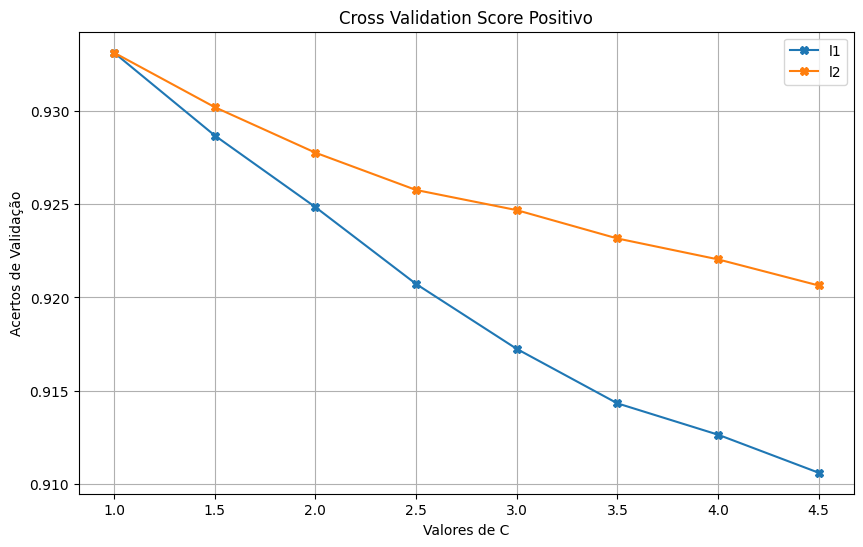

In [31]:
data = loadFile("Dados/bin/svm/parametrosLinearSVC_pos")
crossValidationScore(data, "Positivo")

Segundo os valores obtidos, e o gráfico demonstrado acima, podemos verificar que os melhores valores a utilizar para os valores positivos neste tipo de classificador são: $\textbf{C = 1}$ com uma penalização $\textbf{L2}$. Os melhores valores de acerto para L1 e L2 são iguais sendo esse valor de 93.31% como podemos observar, mas conforme for maior o valor de C tanto a penalização L1 e L2 apresentão um descrescimo sendo mais acentuado em L1. 

Melhor C da Penalização L1:  1.0 | Pior C da Penalização L1:  4.5
Melhor C de Penalização L2:  1.0 | Pior C de Penalização L2:  4.5 

Acerto de Validação do Melhor C da Penalização L1: 0.8886
Acerto de Validação do Melhor C da Penalização L2: 0.8880799999999999 



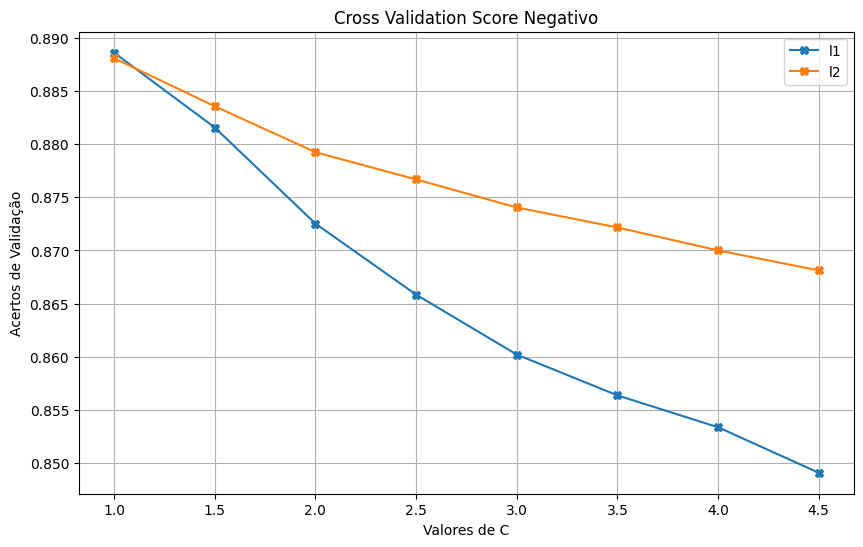

In [17]:
data = loadFile("Dados/bin/svm/parametrosLinearSVC_neg")
crossValidationScore(data,"Negativo")

Para os casos negativos, podemos observar no gráfico acima que os melhores parâmetros mais uma vez são $\textbf{C = 1}$ e para a penalidade será o regularizador $\textbf{L1}$. Também aqui existe um decréscimo percentual dos acertos de validação à medida que o valor do C é maior e mais uma vez, devido a exigencia da penalidade L1, este é o que sofre mais. É de realçar que a diferença percentual das duas penalizações é de 0.06%. 

##### Treino do Classificador

In [ ]:
def SVM_Classifier(X,overallB_test, p, c, filepath):
    svm = LinearSVC(dual=False, penalty=p, C=c, max_iter=5000, tol=1e-2).fit(X, overallB_test)
    saveFile("Dados/"+filepath, svm)

SVM_Classifier(X2,overallB_test_pos, 'l2', 1, 'bin/svm/modeloLinearSVC_test_pos')
SVM_Classifier(X2,overallB_test_neg, 'l1', 1, 'bin/svm/modeloLinearSVC_test_neg')

##### Resultados

Tamanho de Vocabulário (Teste Positivo):  9441 | Score: 97.22%
Número de Erros Teste:  694
Matriz de Confusão: 
 [[23876    13]
 [  681   430]] 

Tamanho de Vocabulário (Teste Negativo):  9441 | Score: 91.1%
Número de Erros Teste:  2225
Matriz de Confusão: 
 [[21263   197]
 [ 2028  1512]] 

Palavras mais relevantes para a classificação:  ['wait', 'glimps', 'reward', 'outstand', 'told', 'finest', 'jame', 'tangy', 'everyon', 'fabul']


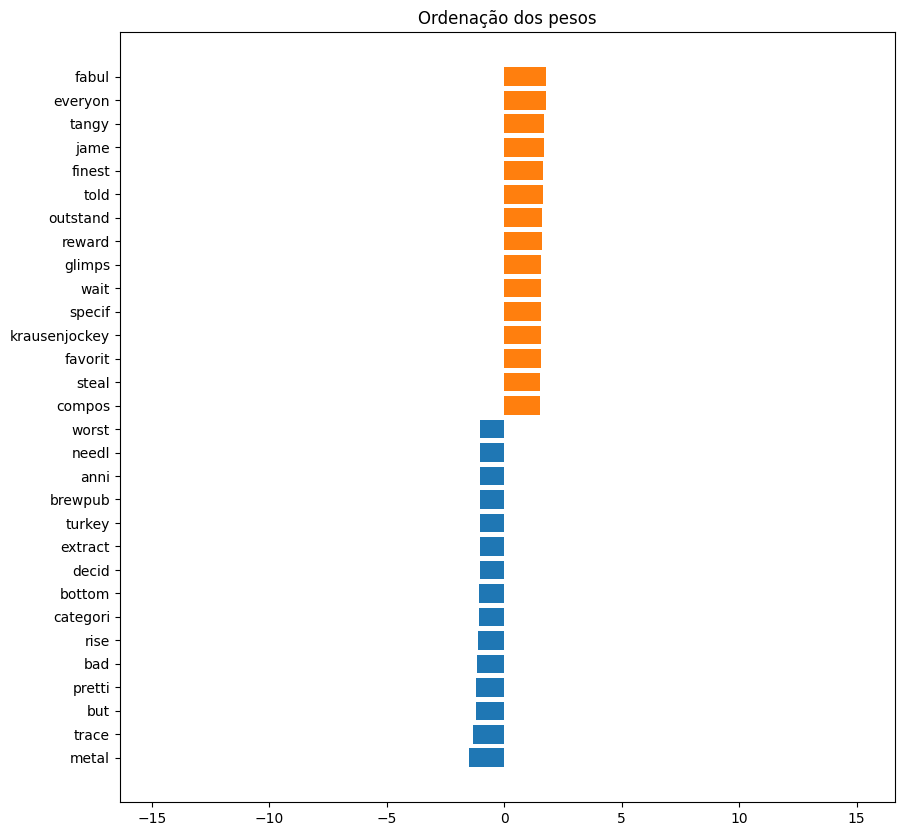

Palavras mais relevantes para a classificação:  ['yike', 'nope', 'earti', 'langu', 'laker', 'mann', 'jerri', 'intic', 'imprint', 'headach']


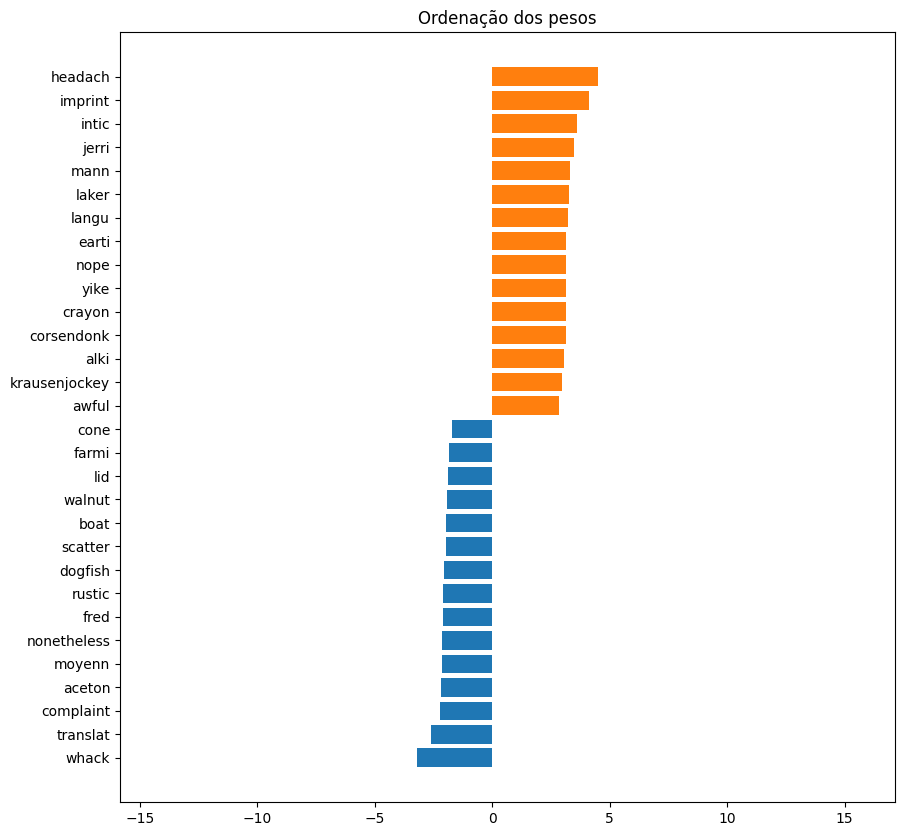

In [32]:
svm_ts_pos = loadFile("Dados/bin/svm/modeloLinearSVC_test_pos")
svm_ts_neg = loadFile("Dados/bin/svm/modeloLinearSVC_test_neg")
Results(tokens_test,svm_ts_pos,X2,overallB_test_pos,"Teste Positivo")
Results(tokens_test,svm_ts_neg,X2,overallB_test_neg,"Teste Negativo")
Vocabulary(svm_ts_pos)
Vocabulary(svm_ts_neg)

A conclusão que se obtem deste classificador é que se obtém um resultado extremamente positivo para ambos os casos de comentários tendo um resultado em média de 94.16% e apenas 2914 erros da sua totalidade. Os gráficos em cima apresentam nos as palavras coms maior pesos nas duas matrizes tendo na positiva **'fabul' , 'everyon','tangy'** no top 3 e na negativa **'headach','imprint', 'intic'** 

#### 4.3.1.2 Regressão Logistica
##### Encontrar os Melhores Valores

In [20]:
def RL_bestCP_finder(overallB,Docs):
    Docs1, Docs2, y1, y2 = train_test_split(Docs, overallB, test_size=1/3, stratify=overallB)
    Docs1t, Docs1v, y1t, y1v = train_test_split(Docs1, y1, test_size=1/2, stratify=y1)
    tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b\w\w\w+\b').fit(Docs1)
    X1v = tfidf.transform(Docs1v)

    Cs = np.arange(1, 5, 0.5) 
    Penalty = ['l1', 'l2'] 
    tuple_CP = [(p, c) for p in Penalty for c in Cs]
    resultados_CP = []
    for p, c in tuple_CP:
        print(p, c)
        dl = LogisticRegression(penalty=p, C=c, random_state=42, solver='saga',max_iter=5000).fit(X1v, y1v)
        scores = cross_val_score(dl, X1v, y1v, cv=5)
        resultados_CP.append(np.mean(scores))
    data = {'parametros': tuple_CP, 'scores': resultados_CP}
    return data

Melhor C da Penalização L1:  1.0 | Pior C da Penalização L1:  4.5
Melhor C de Penalização L2:  2.0 | Pior C de Penalização L2:  3.5 

Acerto de Validação do Melhor C da Penalização L1: 0.9338000000000001
Acerto de Validação do Melhor C da Penalização L2: 0.93528 



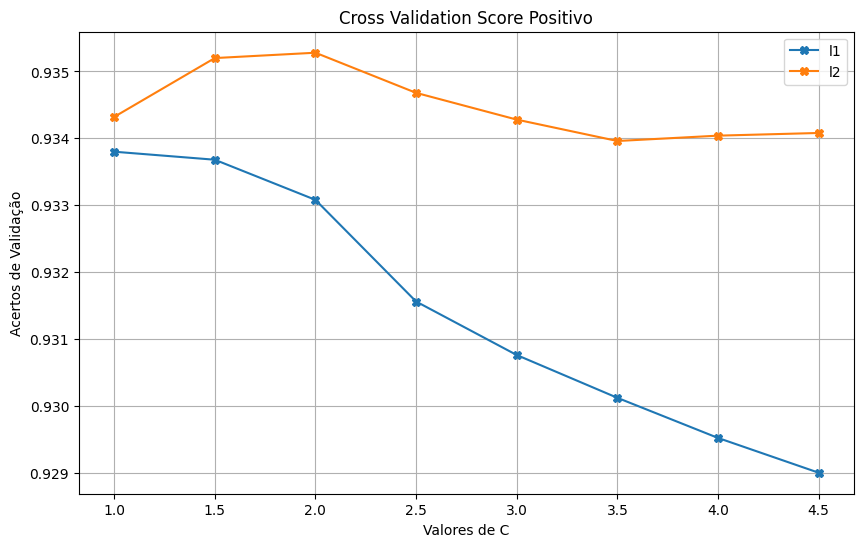

In [21]:
data = loadFile("Dados/bin/rl/parametrosRegLog_pos")
crossValidationScore(data,"Positivo")

Ao contrário ao que foi apresentado na validação cruzada da matriz positiva do SVM, neste classificador os valores são superiores e como uma maior diferença entre penalçizações, como podemos ver no gráfico acima, para este caso, a penalização L2 apresenta sempre uma melhor classificação comparativamente a L1 e tendo o seu melhor ponto quando C = 2. Por isso os parâmetros a serem utilizados nesta matriz serão $\textbf{C = 2 e penalty = L2}$, a diferença entre as penalizações nos seus melhores pontos é de 0.14%

Melhor C da Penalização L1:  1.5 | Pior C da Penalização L1:  4.5
Melhor C de Penalização L2:  2.5 | Pior C de Penalização L2:  4.5 

Acerto de Validação do Melhor C da Penalização L1: 0.8922800000000001
Acerto de Validação do Melhor C da Penalização L2: 0.8918800000000001 



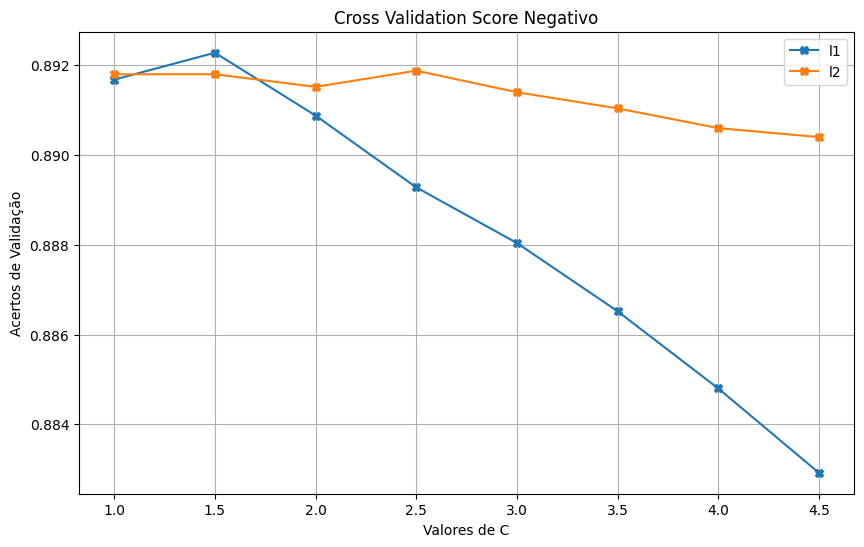

In [22]:
data = loadFile("Dados/bin/rl/parametrosRegLog_neg")
crossValidationScore(data,"Negativo")

Para as classificações negativas, podemos reparar que inicialmente a melhor penalização seria L2 mas no entanto quando C =1.5, existe um pico por parte da penalização L1 em relação a todo o gráfico, o que permite com que este seja a penalização e regularizador C escolhido. $\textbf{C = 1.5, penalty = L1}$, a difernça das penslidades em relação aos seus melhores pontos é igual a 0.04%.

##### Treino Classificador

In [ ]:
def RL_Classifier(X,overallB_test, p, c, filename):
    dl = LogisticRegression(penalty=p, C=c, random_state=42, solver='saga',max_iter=5000).fit(X, overallB_test)
    saveFile("Dados/bin/rl/"+filename, dl)

RL_Classifier(X2,overallB_test_pos, 'l2', 2, 'modeloRL_test_pos')
RL_Classifier(X2,overallB_test_neg, 'l1', 1.5, 'modeloRL_test_neg')

##### Resultados

In [23]:
rl_ts_pos = loadFile("Dados/bin/rl/modeloRL_test_pos")
rl_ts_neg = loadFile("Dados/bin/rl/modeloRL_test_neg")
Results(tokens_test,rl_ts_pos,X2,overallB_test_pos,"Teste Positivo")
Results(tokens_test,rl_ts_neg,X2,overallB_test_neg,"Teste Negativo")
Vocabulary(rl_ts_pos)
Vocabulary(rl_ts_neg)

Tamanho de Vocabulário (Teste Positivo):  9441 | Score: 96.0%
Número de Erros Teste:  1001
Matriz de Confusão: 
 [[23864    25]
 [  976   135]] 

Tamanho de Vocabulário (Teste Negativo):  9441 | Score: 89.1%
Número de Erros Teste:  2725
Matriz de Confusão: 
 [[21176   284]
 [ 2441  1099]] 



Finalmente observamos que o resultado médio deste classificador é igual a 92.55%, com uma totalidade de 3726 erros. Os gráficos de Vocabulários acima aporesentados mostranos-nos dsjkvdlajkbpçidvçojndsfçojhgbçjbjçcvijçdsbvçkbvihfjh  kçljh  

# Classificador Multi-Classe
## SVC

In [25]:
def drawConfusionMatrix(CM_tuple):
    _, axs = plt.subplots(1, len(CM_tuple), figsize=(5*len(CM_tuple), 5))
    for i in range(len(CM_tuple)):
        axs[i].imshow(CM_tuple[i][0],cmap='gray')
        axs[i].set_title('Confusion Matrix '+CM_tuple[i][1])
    plt.show()

Docs_train, overall_train,smell_train,taste_train = DeconstructDict(loadFile('Dados/rateBeer75Ktrain'))
Docs_test, overall_test,smell_test,taste_test = DeconstructDict(loadFile('Dados/rateBeer25Ktest'))

Docs_train_cleaned = textCleaning(Docs_train)
Docs_test_cleaned = textCleaning(Docs_test)

#### Encontrar Melhores Parâmetros

Melhor C da Penalização L1:  1.0 | Pior C da Penalização L1:  4.5
Melhor C de Penalização L2:  1.0 | Pior C de Penalização L2:  4.5 

Acerto de Validação do Melhor C da Penalização L1: 0.25955999999999996
Acerto de Validação do Melhor C da Penalização L2: 0.25708000000000003 



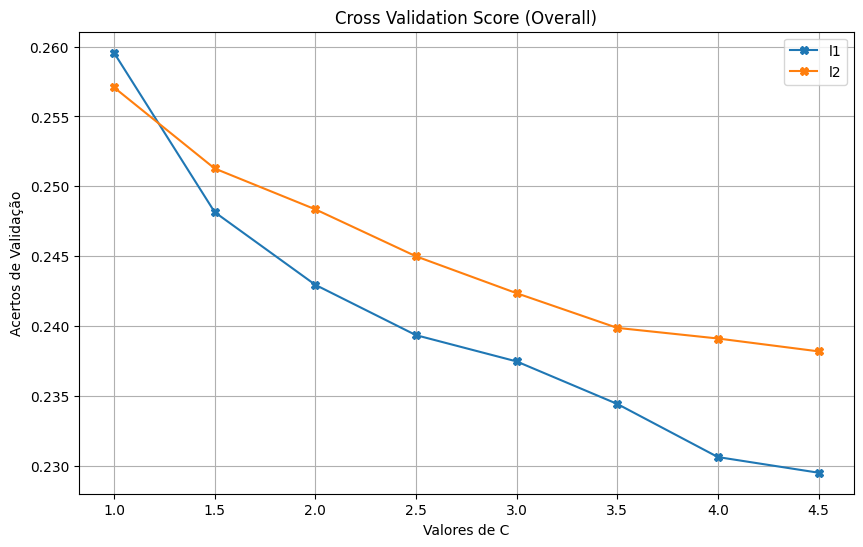

In [26]:
data = loadFile("Dados/multi/svm/parametrosLinearSVC_multi_overall")
crossValidationScore(data,"(Overall)")

Melhor C da Penalização L1:  1.0 | Pior C da Penalização L1:  4.5
Melhor C de Penalização L2:  1.0 | Pior C de Penalização L2:  4.5 

Acerto de Validação do Melhor C da Penalização L1: 0.41844000000000003
Acerto de Validação do Melhor C da Penalização L2: 0.41264 



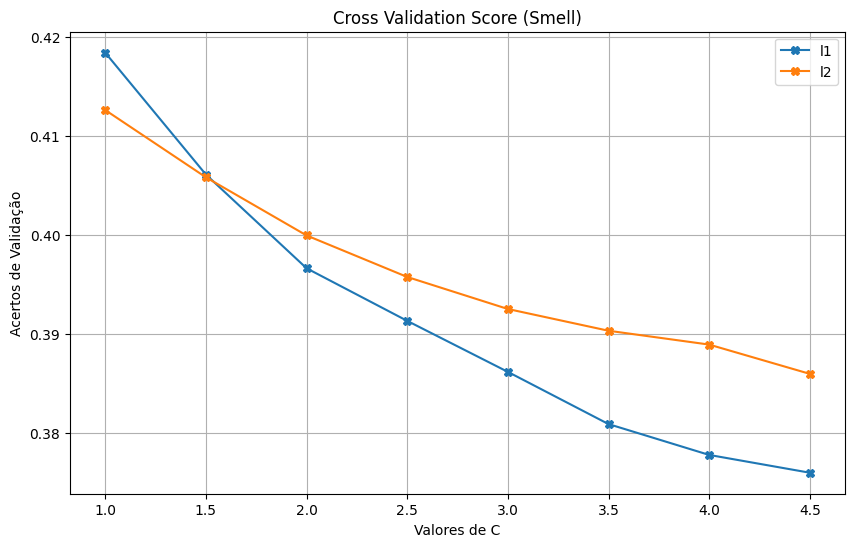

In [27]:
data = loadFile("Dados/multi/svm/parametrosLinearSVC_multi_smell")
crossValidationScore(data,"(Smell)")

Melhor C da Penalização L1:  1.0 | Pior C da Penalização L1:  4.5
Melhor C de Penalização L2:  1.0 | Pior C de Penalização L2:  4.5 

Acerto de Validação do Melhor C da Penalização L1: 0.42892
Acerto de Validação do Melhor C da Penalização L2: 0.42547999999999997 



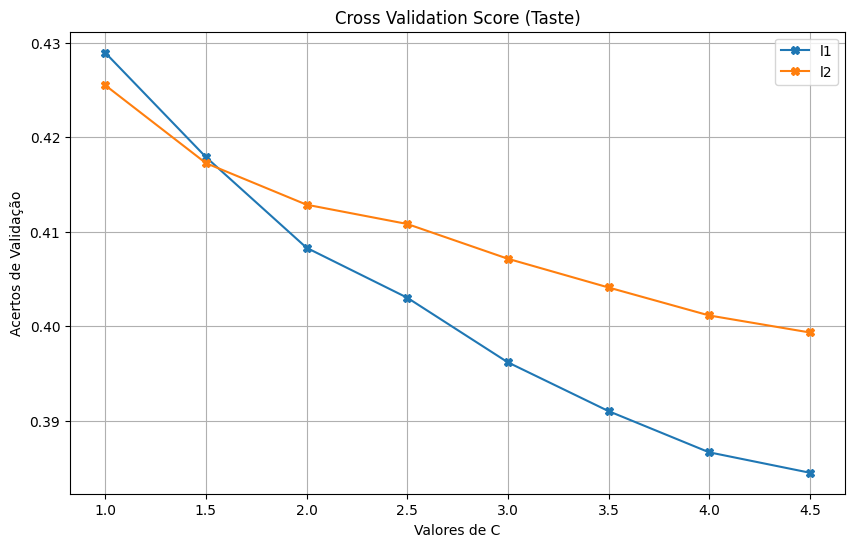

In [28]:
data = loadFile("Dados/multi/svm/parametrosLinearSVC_multi_taste")
crossValidationScore(data,"(Taste)")

In [29]:
SVM_Classifier(X2,overall_test, 'l1', 1.0, 'multi/svm/modeloLinearSVC_test_overall')
SVM_Classifier(X2,smell_test, 'l1', 1.0, 'multi/svm/modeloLinearSVC_test_smell')
SVM_Classifier(X2,taste_test, 'l1', 1.0, 'multi/svm/modeloLinearSVC_test_taste')

svm_ts_overall = loadFile("Dados/multi/svm/modeloLinearSVC_test_overall")
svm_ts_smell = loadFile("Dados/multi/svm/modeloLinearSVC_test_smell")
svm_ts_taste = loadFile("Dados/multi/svm/modeloLinearSVC_test_taste")

Results(tokens_test,svm_ts_overall,X2,overall_test,"Teste (Overall)")
Results(tokens_test,svm_ts_smell,X2,smell_test,"Teste (Smell)")
Results(tokens_test,svm_ts_taste,X2,taste_test,"Teste (Taste)")


Tamanho de Vocabulário (Teste (Overall)):  9441 | Score: 60.9%
Número de Erros Teste:  9775
Matriz de Confusão: 
 [[ 884   24   89  128   10    7    7    3    2    0]
 [ 107  559  199  332   34   23   13    6    2    0]
 [  76   46 1449  832  127  106   51    8    4    0]
 [  41   39  207 4604  328  266  164   44    9    0]
 [  20   21  108 1082 2006  417  247   64   11    1]
 [   8   10   64  672  369 2376  386  105   19    1]
 [   8   10   47  352  228  462 1944  116   31    1]
 [   5    4   18  138  107  305  305  965   25    1]
 [   5    1    6   46   42  135  164  102  365    0]
 [   4    1    4   10   15   35   46   39   18   73]] 

Tamanho de Vocabulário (Teste (Smell)):  9441 | Score: 67.97%
Número de Erros Teste:  8008
Matriz de Confusão: 
 [[3883  503  439   69    4]
 [ 788 3403 1465  267   15]
 [ 368  754 6280  695   26]
 [ 125  251 1387 3034   32]
 [  39   46  272  463  392]] 

Tamanho de Vocabulário (Teste (Taste)):  9441 | Score: 69.35%
Número de Erros Teste:  7662
Matriz

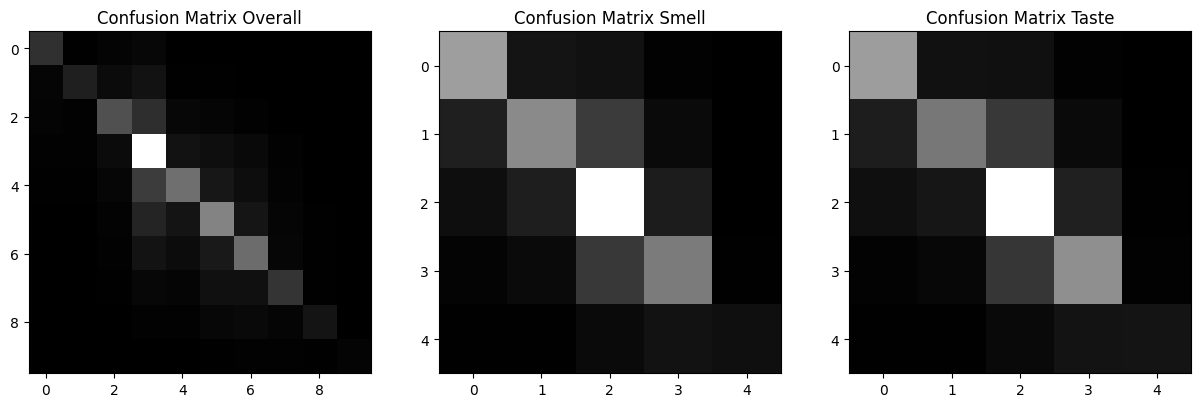

In [30]:
CM_overall = confusion_matrix(overall_test, svm_ts_overall.predict(X2))
CM_smell = confusion_matrix(smell_test, svm_ts_smell.predict(X2))
CM_taste = confusion_matrix(taste_test, svm_ts_taste.predict(X2))
CM_tuple = ((CM_overall, "Overall"), (CM_smell, "Smell"), (CM_taste, "Taste"))
drawConfusionMatrix(CM_tuple)

## Classificadores Adicionais 
### PCA

## Conclusões